In [1]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for notebooks
notebook_dir = os.getcwd()
if 'notebooks' in notebook_dir:
    parent_dir = os.path.dirname(notebook_dir)
    sys.path.insert(0, parent_dir)

# Import configuration
from src import config

# 🎯 ML Heating Learning Dashboard

Quick overview of model learning progress and current parameters.

In [2]:
# Load current model
try:
    with open(config.MODEL_FILE, 'rb') as f:
        model_data = pickle.load(f)
    physics_model = model_data['model']
    mae = model_data.get('mae')
    rmse = model_data.get('rmse')
    print("✓ Model loaded successfully")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    physics_model = None

if physics_model:
    print(f"\n{'='*60}")
    print(f"MODEL STATUS")
    print(f"{'='*60}")
    print(f"Training cycles:     {physics_model.training_count}")
    print(f"MAE:                 {mae.get():.4f}°C" if mae else "MAE: N/A")
    print(f"RMSE:                {rmse.get():.4f}°C" if rmse else "RMSE: N/A")

✓ Model loaded successfully

MODEL STATUS
Training cycles:     3055
MAE:                 0.1871°C
RMSE:                0.2339°C


## 📊 Core Heating Parameters

### How to interpret these values:

**Base Heating Rate** (°C per °C)
- How much indoor temp rises per degree of radiator outlet temp, per 30-min cycle
- Example: 0.000827 means at 50°C outlet and 21°C indoor: `(50-21) × 0.000827 = 0.024°C` warming per cycle
- **Good range:** 0.0005 - 0.001 (depends on home size, insulation, radiator efficiency)
- Higher = faster heating (smaller home or better radiators)

**Target Influence** (°C per °C gap)
- Extra heating boost when target temp is above indoor temp (proportional control)
- Example: 0.008838 means at 1°C gap: adds 0.009°C extra heating per cycle
- **Good range:** 0.005 - 0.03
- This is NOT the main heating - it's a gentle corrective nudge for better responsiveness

**Outdoor Factor** (°C per °C difference)
- Heat loss to environment (weather adjustment)
- Example: 0.003 means 20°C indoor, 0°C outdoor: lose `20 × 0.003 = 0.06°C` per cycle
- **Good range:** 0.002 - 0.005 (depends on insulation quality)
- Higher = more heat loss (worse insulation)

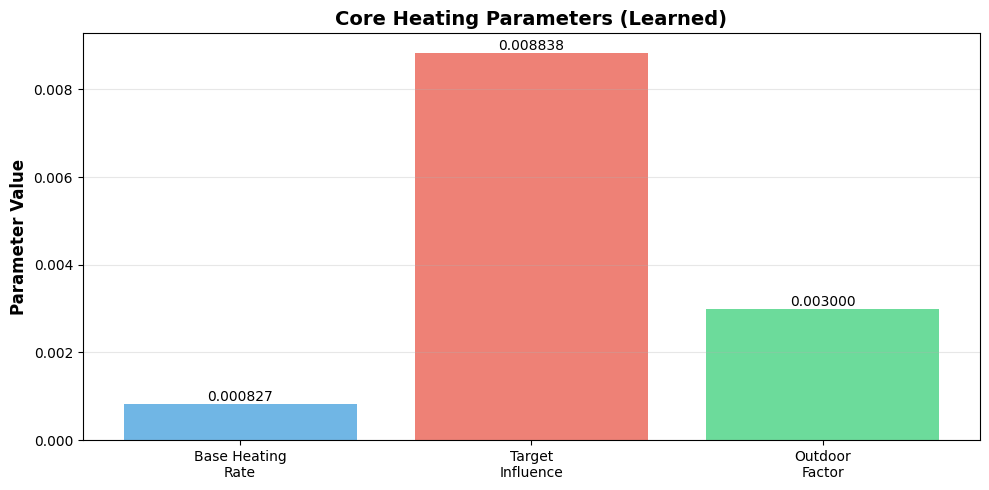

In [3]:
if physics_model:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    params = {
        'Base Heating\nRate': physics_model.base_heating_rate,
        'Target\nInfluence': physics_model.target_influence,
        'Outdoor\nFactor': physics_model.outdoor_factor,
    }
    
    bars = ax.bar(params.keys(), params.values(), color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
    ax.set_ylabel('Parameter Value', fontsize=12, fontweight='bold')
    ax.set_title('Core Heating Parameters (Learned)', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.6f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## 🌞 External Heat Sources

### How to interpret external heat sources:

**Multi-lag Learning** shows time-delayed effects of heat sources:

**PV (Solar Panels)** - Units: °C/100W
- Each bar shows impact at different time delays (30min, 60min, 90min, 120min ago)
- **Total effect:** Sum of all 4 lags (typical: 0.01 - 0.05°C/100W)
- Interpretation: "2000W PV now + 1500W 30min ago + ..." → sum weighted contributions
- Later lags often larger = thermal mass stores and releases heat slowly

**Fireplace** - Units: °C/hr
- Shows immediate effect + 3 time lags (now, 30min, 60min, 90min ago)
- **Total effect:** Sum of all 4 lags (typical: 0.2 - 0.6°C/hr when on)
- Interpretation: Fireplace warms room directly + continues to radiate heat for 90+ minutes
- Larger early lags = room warms quickly when fireplace is on

**TV** - Units: °C
- Shows immediate + 30min lag contribution
- **Total effect:** Sum of both lags (typical: 0.01 - 0.04°C)
- Small but measurable: modern TVs generate 100-200W of heat
- Lag effect = heat slowly spreads through room

**When NOT active:** Uses simple single coefficients (no time delays). Multi-lag activates after 200 training cycles.

✓ Multi-lag learning ACTIVE



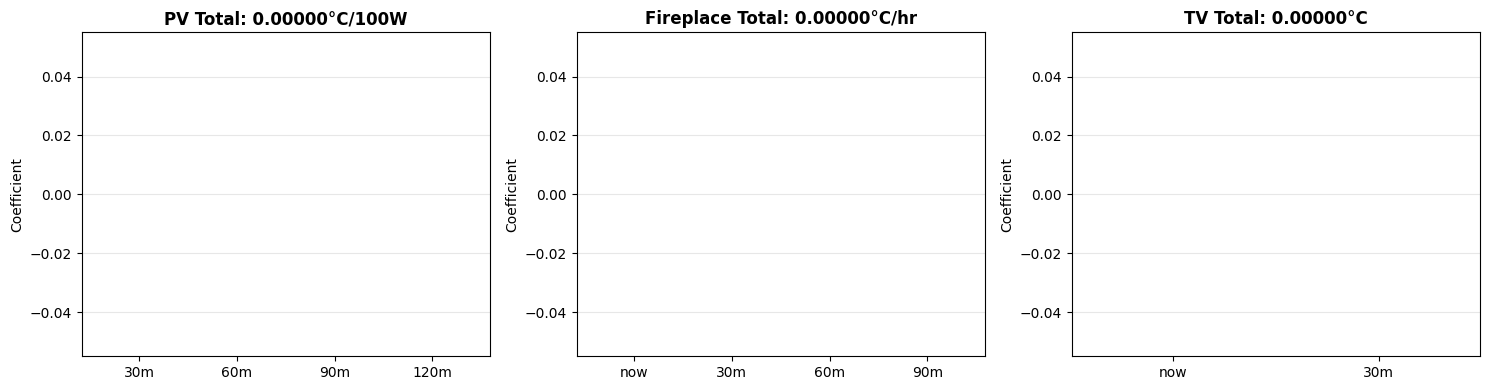

In [4]:
if physics_model:
    # Check if multi-lag is active
    has_multilag = (len(physics_model.pv_effects_detailed) > 0 or 
                    sum(physics_model.pv_coeffs.values()) > 0.0001)
    
    if has_multilag:
        print("✓ Multi-lag learning ACTIVE\n")
        
        # Show total effects
        pv_total = sum(physics_model.pv_coeffs.values())
        fp_total = sum(physics_model.fireplace_coeffs.values())
        tv_total = sum(physics_model.tv_coeffs.values())
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # PV
        pv_data = list(physics_model.pv_coeffs.values())
        axes[0].bar(range(4), pv_data, color='orange', alpha=0.7)
        axes[0].set_title(f'PV Total: {pv_total:.5f}°C/100W', fontweight='bold')
        axes[0].set_xticks(range(4))
        axes[0].set_xticklabels(['30m', '60m', '90m', '120m'])
        axes[0].set_ylabel('Coefficient')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Fireplace
        fp_data = list(physics_model.fireplace_coeffs.values())
        axes[1].bar(range(4), fp_data, color='red', alpha=0.7)
        axes[1].set_title(f'Fireplace Total: {fp_total:.5f}°C/hr', fontweight='bold')
        axes[1].set_xticks(range(4))
        axes[1].set_xticklabels(['now', '30m', '60m', '90m'])
        axes[1].set_ylabel('Coefficient')
        axes[1].grid(axis='y', alpha=0.3)
        
        # TV
        tv_data = list(physics_model.tv_coeffs.values())
        axes[2].bar(range(2), tv_data, color='blue', alpha=0.7)
        axes[2].set_title(f'TV Total: {tv_total:.5f}°C', fontweight='bold')
        axes[2].set_xticks(range(2))
        axes[2].set_xticklabels(['now', '30m'])
        axes[2].set_ylabel('Coefficient')
        axes[2].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ Multi-lag learning NOT YET ACTIVE")
        print(f"   Using simple coefficients:\n")
        print(f"   PV:        {physics_model.pv_warming_coefficient:.6f}°C/100W")
        print(f"   Fireplace: {physics_model.fireplace_heating_rate:.6f}°C/hr")
        print(f"   TV:        {physics_model.tv_heat_contribution:.6f}°C")

## 🗓️ Seasonal Adaptation Status

### How to interpret seasonal patterns:

**Seasonal Multipliers** adjust heat source effects automatically throughout the year:

**Values to look for:**
- **1.0 (baseline):** No seasonal adjustment - shown as black dashed line
- **Above 1.0 (e.g., 1.3):** Heat source 30% MORE effective this month
- **Below 1.0 (e.g., 0.7):** Heat source 30% LESS effective this month

**Why seasonal variation happens:**

**PV (Solar):**
- **Summer (Jun-Aug):** Lower multiplier (0.5-0.7x) 
  - Sun angle changes heat distribution, more ventilation, windows open
- **Winter (Dec-Feb):** Higher multiplier (1.2-1.5x)
  - Better heat retention, closed windows, sun at different angle

**TV:**
- **Summer:** Lower multiplier - more room ventilation
- **Winter:** Higher multiplier - closed rooms retain TV heat better

**Fireplace:**
- No seasonal adjustment (multiplier always 1.0)
- Physical combustion heat doesn't vary by season

**Activation:** Requires 100+ samples during HVAC-off periods (summer) to learn clean baseline effects without heating system interference.

In [5]:
if physics_model:
    has_seasonal = (abs(physics_model.pv_seasonal_cos) > 0.001 or 
                   abs(physics_model.pv_seasonal_sin) > 0.001)
    
    if has_seasonal:
        print("✓ Seasonal learning ACTIVE\n")
        
        # Generate seasonal curves
        months = np.arange(1, 13)
        month_rad = 2 * np.pi * months / 12
        pv_seas = 1.0 + (physics_model.pv_seasonal_cos * np.cos(month_rad) + 
                         physics_model.pv_seasonal_sin * np.sin(month_rad))
        tv_seas = 1.0 + (physics_model.tv_seasonal_cos * np.cos(month_rad) + 
                         physics_model.tv_seasonal_sin * np.sin(month_rad))
        
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(months, pv_seas, 'o-', color='orange', linewidth=2, 
                markersize=8, label=f'PV ({pv_seas.min():.2f}x - {pv_seas.max():.2f}x)')
        ax.plot(months, tv_seas, 's-', color='blue', linewidth=2, 
                markersize=8, label=f'TV ({tv_seas.min():.2f}x - {tv_seas.max():.2f}x)')
        ax.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
        ax.set_xlabel('Month', fontweight='bold')
        ax.set_ylabel('Seasonal Multiplier', fontweight='bold')
        ax.set_title('Seasonal Modulation Patterns', fontsize=14, fontweight='bold')
        ax.set_xticks(months)
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ Seasonal learning NOT YET ACTIVE")
        print(f"   Need {100 - len(physics_model.hvac_off_tracking)} more HVAC-off samples")

⚠ Seasonal learning NOT YET ACTIVE
   Need 100 more HVAC-off samples


## 📈 Learning Progress

### How to interpret learning progress:

**Sample Counts:**
- **Training cycles:** Total 30-min cycles the model has learned from
- **PV/Fireplace/TV samples:** Specific observations when each heat source was active
- **HVAC-off samples:** Summer data when heating is off (needed for clean seasonal learning)

**Learning Milestones:**
- **Cycle 0-200:** 🌱 INITIALIZING - Building history buffers for multi-lag learning
- **Cycle 200-1000:** ⚙ LEARNING - Multi-lag active, coefficients stabilizing
- **Cycle 1000+:** ✓ MATURE - All features operational, high accuracy expected

**Feature Activation:**
- **Multi-lag learning:** Activates at cycle 200 (needs history buffers filled)
  - Until then, uses simple single coefficients
- **Seasonal adaptation:** Activates at 100 HVAC-off samples (typically during summer)
  - Requires clean baseline data without heating system interference

**What to expect:**
- **MAE < 0.30°C:** System learning well
- **MAE < 0.20°C:** Excellent performance (typically after 1000+ cycles)
- **MAE > 0.40°C:** Check for sensor issues or system changes

In [6]:
if physics_model:
    print(f"{'='*60}")
    print(f"SAMPLE COUNTS")
    print(f"{'='*60}")
    print(f"\nTotal cycles:        {physics_model.training_count}")
    print(f"\nDetailed tracking:")
    print(f"  PV samples:        {len(physics_model.pv_effects_detailed)}")
    print(f"  Fireplace samples: {len(physics_model.fireplace_effects_detailed)}")
    print(f"  TV samples:        {len(physics_model.tv_effects_detailed)}")
    print(f"\nSummer learning:")
    print(f"  HVAC-off samples:  {len(physics_model.hvac_off_tracking)}")
    
    print(f"\n{'='*60}")
    print(f"LEARNING MILESTONES")
    print(f"{'='*60}")
    
    if physics_model.training_count >= 1000:
        print("✓ MATURE - All features operational")
    elif physics_model.training_count >= 200:
        print("⚙ LEARNING - Enhanced features active")
        remaining = 1000 - physics_model.training_count
        print(f"  {remaining} cycles until maturity")
    else:
        print("🌱 INITIALIZING - Building history")
        remaining = 200 - physics_model.training_count
        print(f"  {remaining} cycles until multi-lag activation")
    
    # Show what's active
    print(f"\nActive features:")
    if physics_model.training_count >= 200:
        print("  ✓ Multi-lag learning (cycle 200+)")
    else:
        print("  ⏳ Multi-lag learning (activates at cycle 200)")
    
    if len(physics_model.hvac_off_tracking) >= 100:
        print("  ✓ Seasonal adaptation (100+ HVAC-off samples)")
    else:
        print(f"  ⏳ Seasonal adaptation (need {100 - len(physics_model.hvac_off_tracking)} more HVAC-off samples)")

SAMPLE COUNTS

Total cycles:        3055

Detailed tracking:
  PV samples:        14
  Fireplace samples: 0
  TV samples:        0

Summer learning:
  HVAC-off samples:  0

LEARNING MILESTONES
✓ MATURE - All features operational

Active features:
  ✓ Multi-lag learning (cycle 200+)
  ⏳ Seasonal adaptation (need 100 more HVAC-off samples)


## 🎯 Quick Status Summary

### How to interpret the status summary:

**Progress Bars show completeness:**
- **Green (100%+):** Target reached, feature fully mature
- **Orange (50-99%):** Actively learning, making progress
- **Red (0-49%):** Early stage, needs more data

**Training Cycles:** Target = 1000 cycles
- Measures overall model maturity
- Each cycle = 30 minutes of learning

**PV Data Quality:** Target = 50+ samples
- Measures solar panel learning data
- More samples = better PV effect accuracy

**Seasonal Data:** Target = 100+ HVAC-off samples
- Measures summer learning data collection
- Needed for automatic seasonal adaptation

**Overall Status:**
- **✅ FULLY OPERATIONAL (90%+ avg):** All features working optimally, trust the predictions
- **⚙️ LEARNING (50-90% avg):** System improving, continue normal operation
- **🌱 INITIALIZING (<50% avg):** Early stage, allow more time for data collection

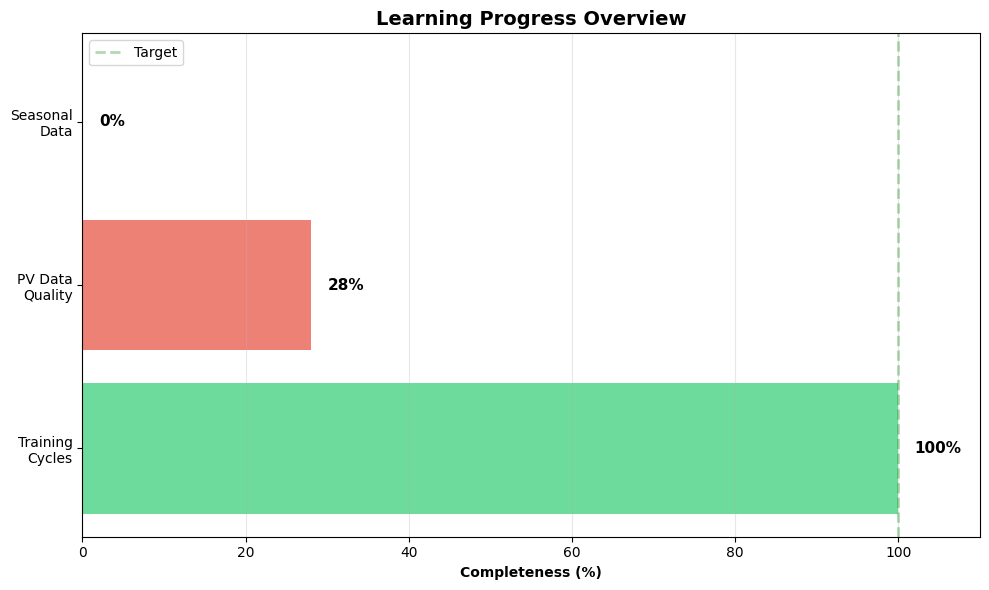


🌱 System is INITIALIZING - allow more time for data collection


In [7]:
if physics_model:
    # Calculate status scores
    cycle_score = min(100, (physics_model.training_count / 1000) * 100)
    pv_score = min(100, (len(physics_model.pv_effects_detailed) / 50) * 100)
    seasonal_score = min(100, (len(physics_model.hvac_off_tracking) / 100) * 100)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['Training\nCycles', 'PV Data\nQuality', 'Seasonal\nData']
    scores = [cycle_score, pv_score, seasonal_score]
    colors = ['#2ecc71' if s >= 100 else '#f39c12' if s >= 50 else '#e74c3c' 
              for s in scores]
    
    bars = ax.barh(categories, scores, color=colors, alpha=0.7)
    ax.set_xlabel('Completeness (%)', fontweight='bold')
    ax.set_title('Learning Progress Overview', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 110)
    ax.axvline(100, color='green', linestyle='--', linewidth=2, alpha=0.3, label='Target')
    
    # Add percentage labels
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax.text(score + 2, i, f'{score:.0f}%', 
                va='center', fontweight='bold', fontsize=11)
    
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Overall recommendation
    print(f"\n{'='*60}")
    avg_score = np.mean(scores)
    if avg_score >= 90:
        print("✅ System is FULLY OPERATIONAL - all features working optimally")
    elif avg_score >= 50:
        print("⚙️  System is LEARNING - continue normal operation")
    else:
        print("🌱 System is INITIALIZING - allow more time for data collection")
    print(f"{'='*60}")